In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from desitarget.targetmask import desi_mask, obsconditions
import desitarget.mtl
import subprocess
import desimodel.io
%matplotlib inline

In [2]:
# Some files to be used
target_file = '/global/cscratch1/sd/raichoor/fiberassign_test/fiberassign_test_05Jul2019_ra242.fits'
mtl_file = './mtl_fiberassign_test_05Jul2019_ra242.fits'
tile_file = './select_tiles.fits'

In [3]:
# read the target data
target_data = Table.read(target_file)

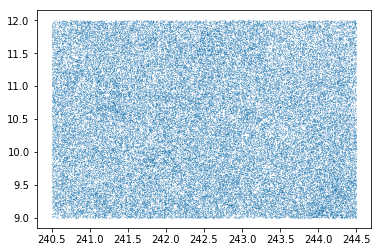

In [4]:
# simple ra-dec plot
plt.scatter(target_data['RA'], target_data['DEC'], s=0.01)

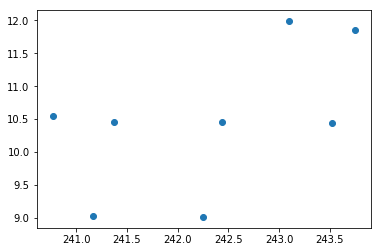

In [5]:
# select DESI tiles that are on the targets and belong to DARK+GRAY programs (i.e not BRIGHT)
tiles = desimodel.io.load_tiles()
ii = tiles['PROGRAM']=='BRIGHT' 
jj = (tiles['RA']>target_data['RA'].min()) 
jj &= (tiles['RA']<target_data['RA'].max())
jj &= (tiles['DEC']>target_data['DEC'].min())
jj &= (tiles['DEC']<target_data['DEC'].max())
select_tiles = tiles[~ii & jj]
plt.scatter(select_tiles['RA'], select_tiles['DEC'])
Table(select_tiles).write(tile_file, overwrite=True)

In [6]:
# Compute MTL file. 
mtl = desitarget.mtl.make_mtl(target_data)
mtl.meta['EXTNAME'] = 'MTL'
mtl.write(mtl_file, overwrite=True)

INFO:mtl.py:119:make_mtl: 6141 of 83943 targets have priority zero, setting N_obs=0.


In [7]:
mtl

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,DEC,BRIGHTBLOB,TARGETID,BGS_TARGET,MWS_TARGET,DESI_TARGET,PRIORITY_INIT,SUBPRIORITY,NUMOBS_INIT,ISADDED,ISMODIFIED,UNIQID,DESI_TARGET_ORIG,ISELGBRIGHT,ISELGMEDIUM,SECOND_MASK,NUMOBS_MORE,PRIORITY,OBSCONDITIONS
int16,int32,str8,int32,str4,float64,float64,int16,int64,int64,int64,int64,int64,float64,int64,bool,bool,str20,int64,bool,bool,int16,int64,int64,int32
8000,385838,2406p095,40,PSF,240.753294084,9.37584202232,2,35185990410698792,0,49,2305843009213693952,1400,0.552243176219,1,False,False,2406p095-40,2305843009213693952,False,False,0,1,1400,7
8000,385838,2406p095,58,REX,240.513142514,9.37623422418,0,35185990410698810,0,0,131586,3000,0.640128627796,1,False,False,2406p095-58,131586,False,False,0,1,3000,3
8000,385838,2406p095,62,PSF,240.66799691,9.37750767826,2,35185990410698814,0,14336,2305843009213693952,1500,0.383285927077,1,False,False,2406p095-62,2305843009213693952,False,False,0,1,1500,7
8000,385838,2406p095,65,DEV,240.559938617,9.3773196054,0,35185990410698817,65793,0,1152921504606846976,2000,0.263435789457,1,False,False,2406p095-65,1152921504606846976,False,False,0,1,2000,7
8000,385838,2406p095,71,PSF,240.600550956,9.37746331713,0,35185990410698823,0,0,263172,3400,0.130989569269,4,False,False,2406p095-71,263172,False,False,0,4,3400,1
8000,385838,2406p095,79,PSF,240.516824051,9.37834024795,2,35185990410698831,0,1792,2305843017803628544,1500,0.0727091785829,1,False,False,2406p095-79,2305843017803628544,False,False,0,1,1500,7
8000,385838,2406p095,101,PSF,240.710082026,9.38016393698,2,35185990410698853,0,1792,2305843017803628544,1500,0.424701561623,1,False,False,2406p095-101,2305843017803628544,False,False,0,1,1500,7
8000,385838,2406p095,120,PSF,240.672884943,9.38291618908,2,35185990410698872,0,49,2305843009213693952,1400,0.734939413419,1,False,False,2406p095-120,2305843009213693952,False,False,0,1,1400,7
8000,385838,2406p095,121,PSF,240.675857525,9.38545961209,2,35185990410698873,0,49,2305843009213693952,1400,0.474524161063,1,False,False,2406p095-121,2305843009213693952,False,False,0,1,1400,7


In [8]:
#run fiberassgin
cmd = 'fba_run --overwrite --targets {} --dir ./fiberassign/ --footprint {}'.format(mtl_file, tile_file)
print(cmd)
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

fba_run --overwrite --targets ./mtl_fiberassign_test_05Jul2019_ra242.fits --dir ./fiberassign/ --footprint ./select_tiles.fits
RUNNING: fba_run --overwrite --targets ./mtl_fiberassign_test_05Jul2019_ra242.fits --dir ./fiberassign/ --footprint ./select_tiles.fits
0


In [9]:
#add target information into tile-*.fits files
cmd = 'fba_merge_results --dir fiberassign/ --targets {}'.format(mtl_file)
print(cmd)
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

fba_merge_results --dir fiberassign/ --targets ./mtl_fiberassign_test_05Jul2019_ra242.fits
RUNNING: fba_merge_results --dir fiberassign/ --targets ./mtl_fiberassign_test_05Jul2019_ra242.fits
0


(240.30012293348634, 244.69995051982391, 8.850052575238724, 12.14989761394626)

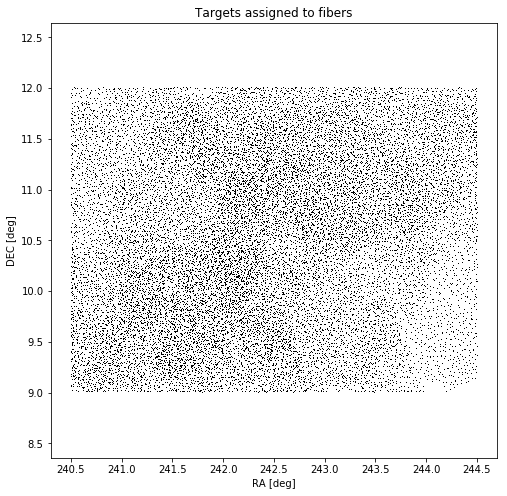

In [10]:
# Gather all outputs
assignments = list()
for tileid in select_tiles['TILEID']:
    tilefile = '{}/tile-{:06d}.fits'.format('fiberassign', tileid)
    assignments.append(Table.read(tilefile, hdu=1))
    
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(mtl['TARGETID'], assigned_targetids)

plt.figure(figsize=(8,8))
plt.plot(mtl['RA'][isAssigned], mtl['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.axis('equal')

(240.3001731938715, 244.69997936572912, 8.8500112366281449, 12.149995689239086)

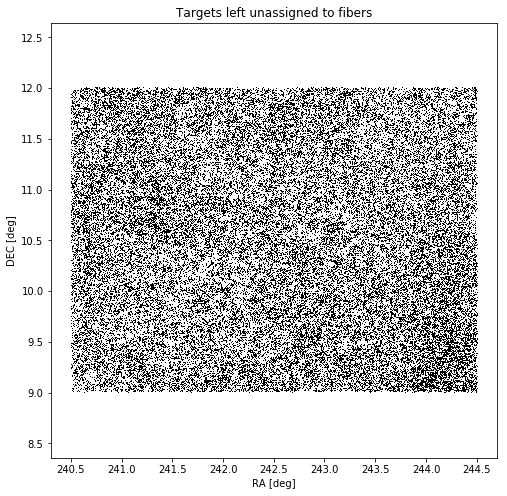

In [11]:
plt.figure(figsize=(8,8))
plt.plot(mtl['RA'][~isAssigned], mtl['DEC'][~isAssigned], 'k,')
plt.title('Targets left unassigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.axis('equal')